### Overview
In this notebook we aim to create real world volatility data.

We will use two approaches to generate the data
1. Using high frequency intraday trading data (up to 2 years of history) from AlphaVantage to generate a better estimate of true volatility
2. Using Yahoo Finance data (20+ years of history) and fitting a GARCH model to the returns

In [3]:
import matplotlib.pyplot as plt
import pyflux as pf
import numpy as np
import math
import csv
import requests
import pandas as pd
import scipy
import time
import os

### Getting Our Data
First we define our function to get data from AlphaVantage. The data is minute by minute intraday stock price information. 

In [4]:
API_KEY = "A2IUEA0TKKGILTDY"

def get_intraday_data(symbol=None, interval="1min", time_slice="year1month1"):

    # check if we have already retrieved the requested data
    csv_path = f"./alpha_vantage_data/{symbol}_{interval}_{time_slice}.csv"
    if os.path.isfile(csv_path):
        # if so just load from the csv
        df = pd.read_csv(csv_path)
    else:
        # if not we query the API for the particular slice of data
        CSV_URL = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={symbol}&interval={interval}&slice={time_slice}&apikey={API_KEY}"
        df = pd.read_csv(CSV_URL)
        print(len(df))
        df.to_csv(csv_path)
        # we slepe for 13 seconds to prevent rate limits from being hit
        # (5 requests per minute)
        time.sleep(13)
    print(len(df))
    return df

### Generating volatility for IBM data
We are now going to generate volatility data for IBM using the intraday trading data over the previous year.

In [5]:
# lets get 1 year of data
IBM_data = pd.concat([get_intraday_data(symbol="AAPL", time_slice=f"year1month{m}") for m in range(1,13)])
#IBM_data = pd.concat([IBM_data] + [get_intraday_data(symbol="IBM", time_slice=f"year2month{m}") for m in range(1,13)])

# convert the time column to date time objects
IBM_data['time'] = pd.to_datetime(IBM_data['time'])

16550
15132
15570
16665
16207
15714
16043
18401
17335
15565
16704
17059


Lets plot the prices over time to see if our data looks ok.

249


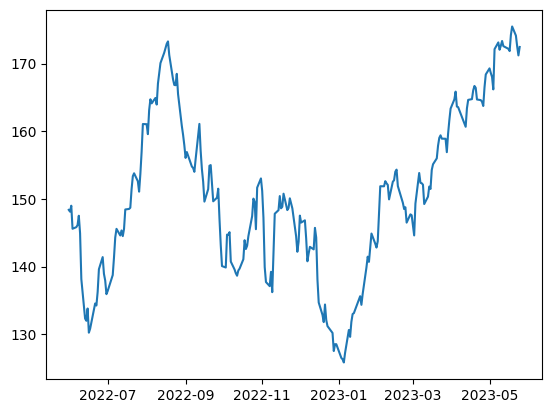

In [6]:
# vol = IBM_data['open'].to_numpy()
# dates = list(IBM_data.index.values)
# plt.plot(dates, vol)


daily_mean_open = IBM_data.groupby([IBM_data['time'].dt.date]).agg(
    mean_open=('open', 'mean'),
)
daily_mean_open = daily_mean_open.sort_index()

dates = list(daily_mean_open.index.values)

print(len(daily_mean_open))

plt.plot(dates, daily_mean_open['mean_open'].to_numpy())

We now perform the following steps to transform this data
1. Take the log of all the price movements
2. Calculate the differences between subsequent log price movements
3. Square these differences
4. Add all the the squared differences for each day
5. Divide each sum by the number of squared differences and then take the square root to get the volatility

In [7]:
# IBM_data['time'] = pd.to_datetime(IBM_data['time'])
IBM_data = IBM_data.sort_values('time')
IBM_data = IBM_data.reset_index(drop=True)
IBM_data['log_open'] = np.log(IBM_data['open'])
IBM_data['log_returns'] = IBM_data["log_open"] - (IBM_data["log_open"][0])
IBM_data['log_returns_sq'] = IBM_data['log_returns'] ** 2
IBM_daily_vol = IBM_data.groupby([IBM_data["time"].dt.date]).agg(  # can also use pd.Grouper(key="time",freq='1D')
    sum_value=('log_returns_sq', 'sum'),
    count_value=('log_returns_sq', 'count')
)
IBM_daily_vol['volatility'] = np.sqrt(IBM_daily_vol['sum_value']/IBM_daily_vol['count_value'])
IBM_daily_vol = IBM_daily_vol.sort_values('time')

Lets plot the volatility and see what it looks like

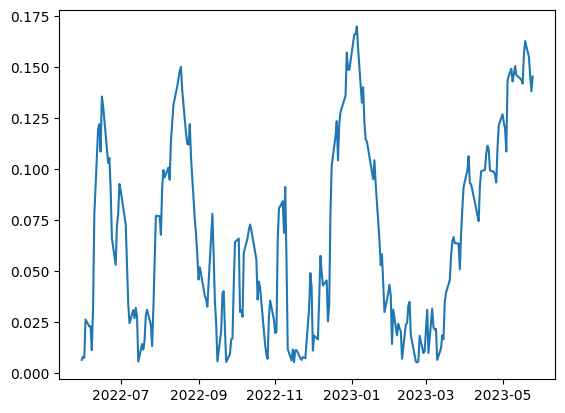

In [8]:
vol=IBM_daily_vol['volatility'].to_numpy()
dates = list(IBM_daily_vol.index.values)
plt.plot(dates[0:400], vol[0:400])

And now lets save our volatility dataframe as a CSV file

In [9]:
volatility_csv_path = f"./volatility_data/AAPL_daily_vol.csv"
IBM_daily_vol.to_csv(volatility_csv_path)

In [10]:
vol_change = daily_data['open'].diff().to_numpy()
vol_change = vol_change[~np.isnan(vol_change)]
counts, bins = np.histogram(vol_change, bins=100)
plt.stairs(counts, bins)

NameError: name 'daily_data' is not defined

### Saving Additional Data
We need to save some additional datasets like daily prices.

In [104]:
# lets get 1 year of data
IBM_data.sort_values('time', ascending=True)
daily_data = IBM_data.groupby([IBM_data["time"].dt.date]).last()
daily_data["log_open"] = np.log(daily_data["open"])
daily_data["log_returns"] = daily_data["log_open"].diff()
#daily_data["log_returns"] = daily_data["log_open"] - daily_data["log_open"][0]
daily_data["volatility"] = np.abs(daily_data["log_returns"])

Lets plot it to check that it looks correct. We'll also plot the daily volatility we calculated earlier from hf data in red as a sanity check.

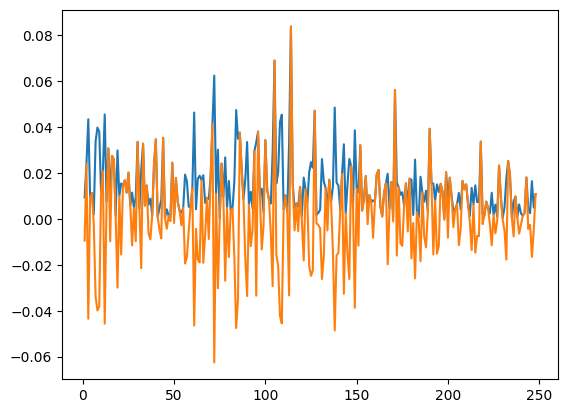

In [105]:
plt.plot(daily_data["volatility"].to_numpy())
#plt.plot(vol, c='r', linewidth=0.4)

plt.plot(daily_data["log_returns"].to_numpy())

Ok lets save this data

In [146]:
daily_data.to_csv("./price_data/AAPL_daily_price_data")

### Yahoo Finance data with GARCH model
We will now use yahoo finance historical daily trading data. 

We will then caluclate the log returns of the series and then fit a GARCH model to that data

First lets load our dataset

In [12]:
daily_data = pd.read_csv("./yahoo_finance_data/AAPL.csv")


Now lets use the pyflux package to perform analysis.

0.0012311718750306047


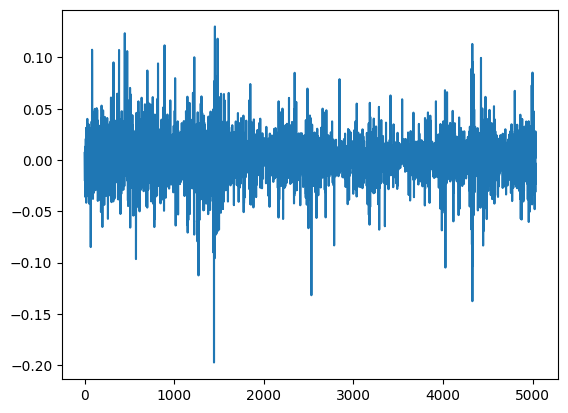

In [67]:
daily_data["log_returns"] = np.log(daily_data["Close"]).diff()
plt.plot(daily_data["log_returns"].to_numpy())
print(daily_data["log_returns"].to_numpy()[1:].mean())

In [68]:
garch_model = pf.GARCH(daily_data["log_returns"].to_numpy(), p=2, q=2)

In [69]:
result = garch_model.fit()

In [70]:
print(result.summary())

GARCH(2,2)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 2                                           Log Likelihood: 12623.055                         
End Date: 5034                                          AIC: -25234.1101                                  
Number of observations: 5033                            BIC: -25194.9675                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0001                                                           
q(1)                                 

Now lets build our GARCH model from these paramters 

In [71]:
def garch_pred(returns, conditional_vol, i):
    const_term = 0.0001
    q1 = 0.1659
    q2 = 0.018
    p1 = 0.6535
    p2 = 0.0187
    r1 = returns[i]
    r2 = returns[i-1]
    cv1 = conditional_vol[i]
    cv2 = conditional_vol[i-1]
    return math.sqrt(const_term + q1*r1**2 + q2*r2**2 + p1*cv1**2 + p2*cv2**2)

In [74]:
returns = daily_data["log_returns"].to_numpy()[1:] #- 0.0021

conditional_vol = np.zeros_like(returns)
conditional_vol[0] = 0.02
conditional_vol[1] = 0.02

for i in range(1, len(returns) - 1):
    conditional_vol[i + 1] = garch_pred(returns, conditional_vol, i)


Lets plot a section of our data to see how it looks

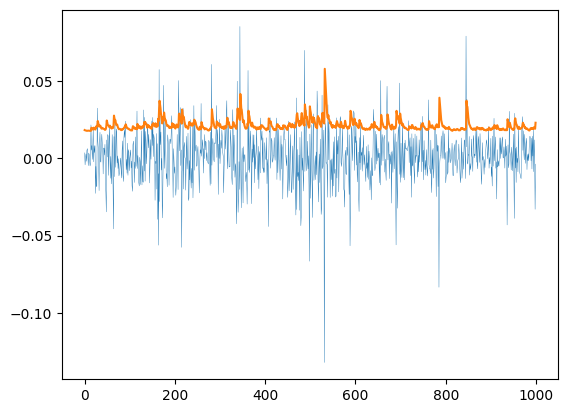

In [75]:
plt.plot(returns[2000:3000], linewidth=0.3)
plt.plot(conditional_vol[2000:3000])

great, now lets save our data into a new dataframe

In [81]:
saved_dataframe = pd.DataFrame({
    "date": daily_data["Date"].to_numpy()[1:],  # get rid of the first date as it has NaN data
    "returns": returns,
    "volatility": conditional_vol
})

saved_dataframe.to_csv("./volatility_data/AAPL_20_year_daily_vol.csv")